# [Lab] Gaussian Discriminative Analysis (GDA)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from IPython.display import clear_output
import math
from numpy.linalg import inv
from numpy.linalg import det
from numpy.linalg import norm

## 2. Read the data file, considering 80% of data as the training set and the rest for the test set.

In [2]:
data = np.genfromtxt('../data.csv', delimiter=',')

In [3]:
split = 80
np.random.shuffle(data)
train, test = data[:split],data[split:]

## 3. Solve the classification problem using both methods that you learned in class (the training part):

### a. Logistic regression (an example of discriminative models)

In [4]:
def hypothesis(X, thetas):
    return 1/(1+np.exp(-np.dot(X,thetas)))

In [5]:
def log_likelihood(y,predictions):
    ll = np.sum(y*np.log(predictions)+1-y*np.log(1-predictions))
    return ll

In [6]:
def train_logistic_regression(X,y,thetas, alpha, epsilon, patience):
    thetas_evo = [],[]
    loglkh_evo = [] # List of log likelyhood evolution
    loglkh= 0
    delta_loglkh=0
    n_iter = 0
    stop = 0
    
    while (stop != patience):
        n_iter+=1

        predictions = hypothesis(X,thetas)                         # Update predictions
        thetas = thetas + alpha*(np.dot(X.T,(y-predictions)))      #(2,1) = (2,1) - a((2,80)*((80,1)-(80,1)))
        thetas_evo  = np.concatenate((thetas_evo, thetas), axis=1) #Store thetas evolution
        
        loglkh_old = loglkh                       # Store likelyhood
        loglkh = log_likelihood(y,predictions)    # Update log likelihood
        loglkh_evo = np.append(loglkh_evo,loglkh) # Store likelihood evolution
        delta_loglkh_old = delta_loglkh           # Store likelihood difference
        if(n_iter>1):
            delta_loglkh=abs(loglkh - loglkh_old)  # Update likelihood difference
        
        if((delta_loglkh < epsilon) and (delta_loglkh_old < epsilon)): 
            stop+=1  #if the current and previous likelihood difference is lesser than espilon, increment the stopping variable
        else :
            stop = 0 # if log likelihood difference has improved or hasn't converged
    return thetas_evo, loglkh_evo

### b. Gaussian Discriminant Analysis (an example of generative models)

#### Computes GDA parameters

In [7]:
def compute_phi(Y):  # Scalar
    return np.count_nonzero(Y)/len(Y)

def compute_mu(X,Y): # return (2,1),(2,1)
    num_0 = num_1 = np.array([[0],[0]])
    denum_1 = denum_0 = 0
    for i,y in enumerate(Y):
        if (y == 0):
            num_0  = X[i] + num_0 
            denum_0 += 1
        else:
            num_1  = X[i] + num_1
            denum_1 += 1
    return (num_0/denum_0),(num_1/denum_1)

def compute_sigma(X,Y,mu_0,mu_1):
    sum_mu=0
    for i,y in enumerate(Y):
        if (y == 0):                            
            sum_mu += (X[i]-mu_0)*(X[i]-mu_0).T # If y=0, Mu_0 is used
        else:
            sum_mu += (X[i]-mu_1)*(X[i]-mu_1).T # Else Mu_1 is used
    return sum_mu/len(Y)

#### Computes GDA probabilities

In [8]:
def compute_Px_y(x,y,mu, sigma): # Compute P(x|y) for one example
    n = len(x)
    a = 1/(((2*math.pi)**(n/2))*norm(sigma))  # Scalar
    b = np.exp(np.dot(np.dot(-0.5*(x-mu).T,inv(sigma)),(x-mu))) #((2,1)-(2,1)).T * (2,2) * (2,2)-(2,1) = (1,1)
    return a/b

#predictions
def compute_Py_x(x,y,phi,mu_0,mu_1,sigma):
    Px_y0_Py = compute_Px_y(x,y,mu_0,sigma)*(1-phi) # P(x|y=0)*P(y=0)
    Px_y1_Py = compute_Px_y(x,y,mu_1,sigma)*phi     # P(x|y=1)*P(y=1)
    return np.array([Px_y0_Py,Px_y1_Py])        # P(x|y=0)*P(y) and P(x|y=1)*P(y)

#### Computes GDA joint likelyhood

In [9]:
#Define joint log likelihood depending on model parameters
def joint_log_likelihood(X,Y,phi,mu_0,mu_1,sigma):
    a = 1
    for i,x in enumerate(X):
        if (Y[i] == 0):
            a = a*compute_Px_y(x,Y[i],mu_0,sigma)*(1-phi)
        else:
            a = a*compute_Px_y(x,Y[i],mu_1,sigma)*phi    
    return np.log(a)

#### Computes GDA 

In [10]:
def compute_GDA(X,Y):
    mu_0 = mu_1 = 0
    
    phi = compute_phi(Y)                 # Compute Phi
    mu_0, mu_1 = compute_mu(X,Y)         # Computes Mus
    sigma = compute_sigma(X,Y,mu_0,mu_1) # Compute Sigma
    
    loglkh = joint_log_likelihood(X,Y,phi,mu_0,mu_1,sigma) # Compute joint log likelihood

    return phi,mu_0,mu_1, sigma, loglkh

#### Computes predictions

In [11]:
def hypothesis_2(X,Y,phi,mu_0,mu_1,sigma):
    predictions = []
    for i,x in enumerate(X):
        a,b = compute_Py_x(x, Y[i,0],phi,mu_0,mu_1,sigma)
        c = np.argmin(np.array([a,b]))
        predictions = np.append(predictions,c)
    return predictions.reshape(Y.size,1)

### Trainings

In [12]:
X_train = train[:, [0, 1]] # Inputs are the first two columns
y_train = train[:, [2]]    # Outputs are the last column
X_train_r = X_train.reshape(len(X_train),2,1) #reshaped X_train

Text(0,0.5,'x1')

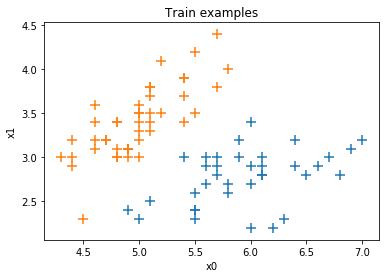

In [13]:
colors=['tab:orange' if l==0 else 'tab:blue' for l in y_train]
plt.scatter(X_train[:,0], X_train[:,1],s=100, color = colors, marker='+')
plt.title('Train examples')
plt.xlabel('x0')
plt.ylabel('x1')

#### Logistic Regression

In [14]:
epsilon = 0.001 # Convergence value
patience = 3
alpha = 0.001

theta_0 = random.uniform(0, 1)
theta_1 = random.uniform(0, 1)
thetas = np.array([[theta_0],[theta_1]]) # Regroupement of all thetas

In [15]:
thetas, likelihood_lr = train_logistic_regression(X_train,y_train,thetas, alpha, epsilon, patience)
print("Theta 0 = ", thetas[0,-1],"Theta 1 = ",thetas[1,-1])

Theta 0 =  6.2613740556788695 Theta 1 =  -11.003612306383529


#### evolution of log likelihood

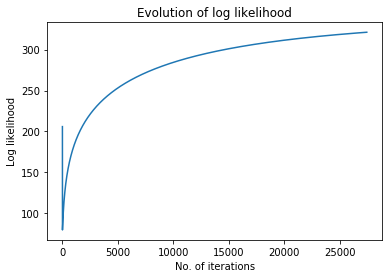

In [16]:
plt.title('Evolution of log likelihood')
plt.xlabel('No. of iterations')
plt.ylabel('Log likelihood')
plt.plot(likelihood_lr)
#plt.plot(likelihood_gda)

Text(0,0.5,'Thetas')

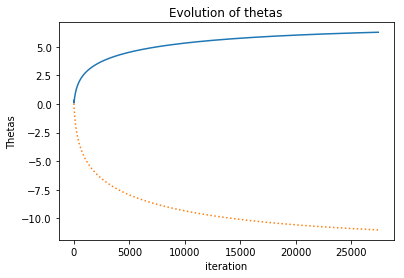

In [17]:
plt.title('Evolution of thetas')
plt.plot(thetas[0,:])
plt.plot(thetas[1,:], linestyle=':')
plt.xlabel('iteration')
plt.ylabel('Thetas')

#### Gaussian Discriminant Analysis

In [18]:
phi,mu_0,mu_1, sigma, likelihood_gda = compute_GDA(X_train_r,y_train)
print("Phi = ", phi,"\nMu 0 = ", mu_0,"\nMu 1 = ", mu_1,"\nSigma = ", sigma,"\nJoint log likelyhood = ", likelihood_gda)

Phi =  0.45 
Mu 0 =  [[4.98181818]
 [3.40227273]] 
Mu 1 =  [[5.94166667]
 [2.77222222]] 
Sigma =  [[0.18641193 0.09029356]
 [0.09029356 0.12777494]] 
Joint log likelyhood =  [[-14.18599617]]


## 4. Compare the results of training with the two methods.

### Confusion Matrix and F1 score

In [19]:
def confusion_matrix(y,predictions):
    TP = FP = TN = FN = 0 #Initialize counters to zero
    for i, pred in enumerate (predictions):
        if(pred == 1):        # Positive
            if(pred == y[i]): # True Positive
                TP+=1
            else:             # False Positive
                FP+=1
        else:                 # Negative
            if(pred == y[i]): # True Negative
                TN+=1
            else:             # False Negative
                FN+=1
    return TP,FP,FN,TN

def f1_score(TP,FP,FN,TN):
    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    f1 = 2*((precision*recall)/(precision+recall))
    return f1

### Compute predictions and F1 score

#### Logistic Regression:

In [20]:
t = np.array([[thetas[0,-1]],[thetas[1,-1]]])
predictions_lr = hypothesis(X_train,t)

Text(0,0.5,'x1')

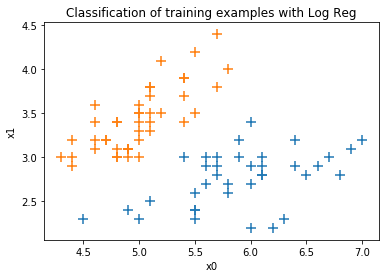

In [21]:
colors=['tab:orange' if l==0 else 'tab:blue' for l in np.round(predictions_lr)]
plt.scatter(X_train[:,0], X_train[:,1],s=100, color = colors, marker='+')
plt.title('Classification of training examples with Log Reg')
plt.xlabel('x0')
plt.ylabel('x1')

In [22]:
TP,FP,FN,TN = confusion_matrix(y_train,np.round(predictions_lr))
print("TP:",TP," FP:",FP," FN:",FN," TN:",TN)
print("Logistic regression f1_score =", f1_score(TP,FP,FN,TN))

TP: 36  FP: 1  FN: 0  TN: 43
Logistic regression f1_score = 0.9863013698630138


#### Gaussian Discriminant Analysis:

In [23]:
predictions_gda = hypothesis_2(X_train_r,y_train,phi,mu_0,mu_1,sigma)

Text(0,0.5,'x1')

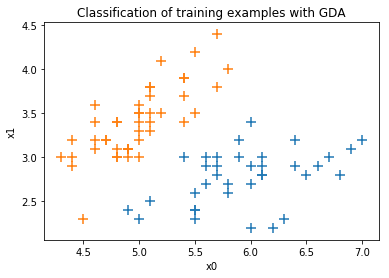

In [24]:
colors=['tab:orange' if l==0 else 'tab:blue' for l in predictions_gda]
plt.scatter(X_train[:,0], X_train[:,1],s=100, color = colors, marker='+')
plt.title('Classification of training examples with GDA')
plt.xlabel('x0')
plt.ylabel('x1')

In [25]:
TP,FP,FN,TN = confusion_matrix(y_train,np.round(predictions_gda))
print("TP:",TP," FP:",FP," FN:",FN," TN:",TN)
print("Gaussian Discriminant Analysis f1_score =", f1_score(TP,FP,FN,TN))

TP: 36  FP: 0  FN: 0  TN: 44
Gaussian Discriminant Analysis f1_score = 1.0


## 5. Test the optimized parameters with the test data

In [26]:
X_test = test[:, [0, 1]] # Test inputs are the first two columns
y_test = test[:, [2]]    # Test outputs are the last column

Text(0,0.5,'x1')

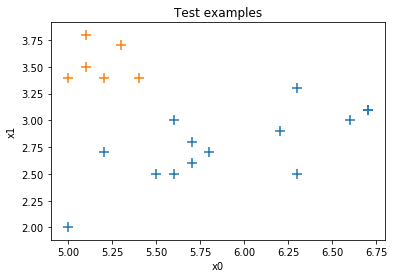

In [27]:
colors=['tab:orange' if l==0 else 'tab:blue' for l in y_test]
plt.scatter(X_test[:,0], X_test[:,1],s=100, color = colors, marker='+')
plt.title('Test examples')
plt.xlabel('x0')
plt.ylabel('x1')

### Compute predictions and F1 score on test examples

#### Logistic Regression:

In [28]:
t = np.array([[thetas[0,-1]],[thetas[1,-1]]])
predictions_lr = hypothesis(X_test,t)

Text(0,0.5,'x1')

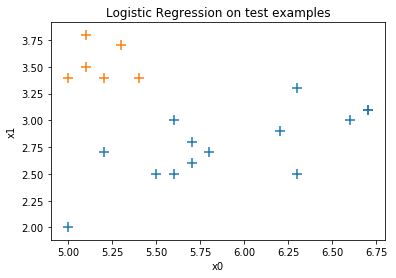

In [29]:
colors=['tab:orange' if l==0 else 'tab:blue' for l in np.round(predictions_lr)]
plt.scatter(X_test[:,0], X_test[:,1],s=100, color = colors, marker='+')
plt.title('Logistic Regression on test examples')
plt.xlabel('x0')
plt.ylabel('x1')

In [31]:
TP,FP,FN,TN = confusion_matrix(y_train,np.round(predictions_lr))
print("TP:",TP," FP:",FP," FN:",FN," TN:",TN)
print("Logistic regression f1_score =", f1_score(TP,FP,FN,TN))

TP: 6  FP: 8  FN: 1  TN: 5
Logistic regression f1_score = 0.5714285714285714


#### Gaussian Discriminant Analysis:

In [32]:
predictions_gda = hypothesis_2(X_test.reshape(y_test.size,2,1),y_test,phi, mu_0,mu_1,sigma)

Text(0,0.5,'x1')

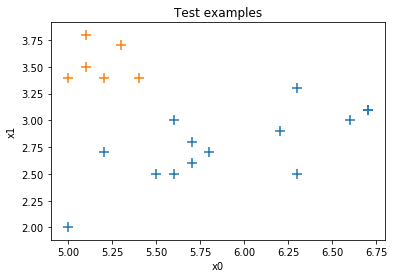

In [33]:
colors=['tab:orange' if l==0 else 'tab:blue' for l in predictions_gda]
plt.scatter(X_test[:,0], X_test[:,1],s=100, color = colors, marker='+')
plt.title('Test examples')
plt.xlabel('x0')
plt.ylabel('x1')

In [34]:
TP,FP,FN,TN = confusion_matrix(y_train,np.round(predictions_gda))
print("TP:",TP," FP:",FP," FN:",FN," TN:",TN)
print("Gaussian Discriminant Analysis f1_score =", f1_score(TP,FP,FN,TN))

TP: 6  FP: 8  FN: 1  TN: 5
Gaussian Discriminant Analysis f1_score = 0.5714285714285714


Text(0,0.5,'x1')

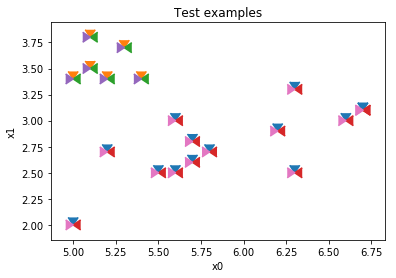

In [35]:
colors=['tab:orange' if l==0 else 'tab:blue' for l in y_test]
plt.scatter(X_test[:,0], X_test[:,1],s=100, color = colors, marker=7)
colors=['tab:green' if l==0 else 'tab:red' for l in np.round(predictions_lr)]
plt.scatter(X_test[:,0], X_test[:,1],s=100, color = colors, marker=4)
colors=['tab:purple' if l==0 else 'tab:pink' for l in predictions_gda]
plt.scatter(X_test[:,0], X_test[:,1],s=100, color = colors, marker=5)
plt.title('Test examples')
plt.xlabel('x0')
plt.ylabel('x1')

### Heatmap, white is 0, black is 1

In [36]:
x = np.arange(4, 7, 0.1)
y = np.arange(2, 5, 0.1)
xx, yy = np.meshgrid(x, y)
coord = np.concatenate((xx.reshape(900,1), yy.reshape(900,1)), axis=1)
coord.shape

(900, 2)

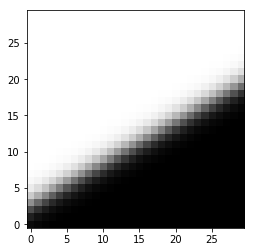

In [37]:
plt.imshow(hypothesis(coord,t).reshape(30,30), cmap='binary')
plt.gca().invert_yaxis()